In [1]:
import scipy.io
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from model.utils import loadHSI,calculate_aligned_accuracy
from lund.utils import GraphExtractor, diffusion_distance
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from scipy.spatial.distance import pdist, squareform

Xmat = scipy.io.loadmat('X.mat')
Ymat = scipy.io.loadmat('Y.mat')

In [2]:
X = Xmat["X"]
GT = Ymat['Y']

In [3]:
def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()

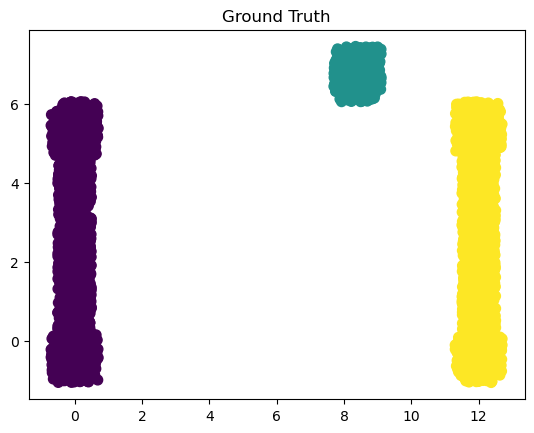

In [4]:
plot_clusters(X, GT, "Ground Truth")

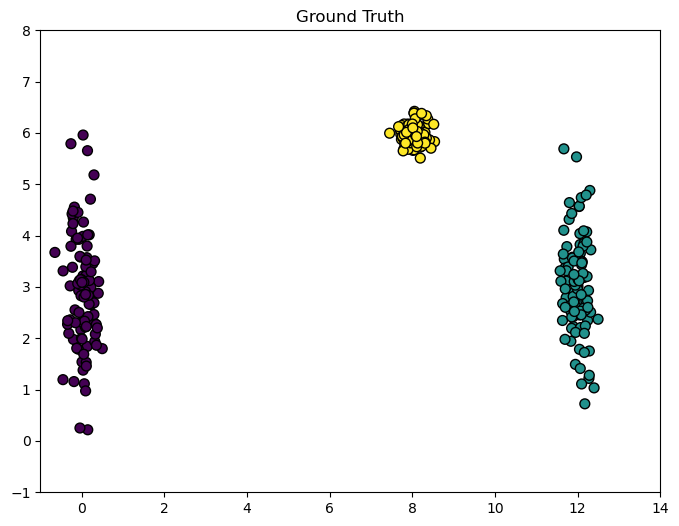

In [3]:
import numpy as np

# Generate data for the first cluster
# left cluster
cluster_1_x = np.random.normal(loc=0, scale=0.2, size=100)
cluster_1_y = np.random.normal(loc=3, scale=1.0, size=100)

# center cluster
cluster_3_x = np.random.normal(loc=8, scale=0.2, size=100)
cluster_3_y = np.random.normal(loc=6, scale=0.2, size=100)

# Generate data for the second cluster
# right cluster
cluster_2_x = np.random.normal(loc=12, scale=0.2, size=100)
cluster_2_y = np.random.normal(loc=3, scale=1.0, size=100)


# Combine all clusters
X = np.hstack((cluster_1_x, cluster_2_x, cluster_3_x))
GT = np.hstack((cluster_1_y, cluster_2_y, cluster_3_y))

# Create labels for clusters
labels = np.array([0] * 100 + [1] * 100 + [2] * 100)

# Plot the data with clusters
plt.figure(figsize=(8, 6))
plt.scatter(X, GT, c=labels, cmap='viridis', s=50, edgecolor='k')
plt.title('Ground Truth')
plt.xlim(-1, 14)
plt.ylim(-1, 8)
plt.show()

In [4]:
kde = KernelDensity(bandwidth=1.0)
kde.fit(X)
log_density = kde.score_samples(X)
p = np.exp(log_density)
print(p.shape)

graph_extractor = GraphExtractor(sigma = 0.5, DiffusionNN = 10)
G = graph_extractor.extract_graph(X)


C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, 30, G, p)


accuracy = calculate_aligned_accuracy(GT, C)
print("Aligned Accuracy:", accuracy)

plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f})")
plot_clusters(X, GT, "Ground Truth")

ValueError: Expected 2D array, got 1D array instead:
array=[ 1.07964491e-01 -1.66841057e-02  9.16965306e-02  2.75412027e-01
  3.54577175e-02 -2.75583571e-01  1.76843889e-01 -1.96657622e-01
  3.09635236e-01  3.72803485e-02  1.09318328e-02  1.42968590e-01
  1.37227119e-01  6.69426911e-02  1.84913066e-01 -1.73304482e-01
  1.29424861e-01  1.27696726e-01 -4.49781367e-01  1.50845472e-01
  1.11722764e-01 -1.58199530e-01 -6.10776585e-02  4.13975832e-01
 -2.56989029e-01 -1.30903857e-01 -2.74402726e-01  3.20013893e-01
  4.03676791e-01  2.99325731e-01  1.34508570e-01  1.15101706e-01
  3.33778528e-01 -2.42082369e-01  2.28436141e-01  2.55485348e-01
  5.00626117e-01  1.06114329e-01  2.25358182e-01 -6.83860241e-02
 -1.91102809e-03 -3.09403923e-03 -2.00560358e-01  3.00510335e-01
  9.71431181e-02  1.83974406e-01 -3.08691815e-01  3.56033308e-01
  3.14923256e-01  2.14847486e-01  3.00851652e-01  1.90005072e-01
 -2.56484914e-01  6.58137851e-02  3.27654971e-02  1.43766712e-01
 -2.28604142e-02 -2.29323503e-01 -3.37973332e-01 -8.76039398e-02
  1.04006089e-01 -7.89729948e-02  1.55052331e-01 -2.06220457e-01
  1.49068621e-01 -5.44713925e-02  1.94669137e-02 -1.25009227e-02
 -1.83398512e-01  1.32265662e-02 -6.44783728e-01  2.30071773e-01
  3.80841202e-01  4.64565538e-02  3.71748448e-02  7.15922016e-02
  1.50061845e-01 -2.08524650e-02 -3.97730913e-02 -9.31050012e-02
 -1.16272623e-01 -2.07451505e-01  1.66892491e-01  3.59839491e-01
 -1.48707845e-01 -2.54856178e-02 -6.31634078e-02  5.72898451e-02
  5.84082464e-02 -3.34767512e-01  9.62804054e-02 -3.87204266e-02
 -9.68575913e-02  1.15961497e-01  9.79623075e-02  1.07245295e-02
 -2.19768467e-01  5.29878595e-02  1.11377369e-01 -4.46088497e-01
  1.17965092e+01  1.21350512e+01  1.22846262e+01  1.21518771e+01
  1.20631111e+01  1.19748850e+01  1.19157780e+01  1.24962440e+01
  1.16794270e+01  1.16671880e+01  1.20090940e+01  1.22443812e+01
  1.23163858e+01  1.18974139e+01  1.19481872e+01  1.21176472e+01
  1.16932474e+01  1.21676965e+01  1.18768979e+01  1.23205380e+01
  1.17235334e+01  1.19804361e+01  1.17413790e+01  1.23996643e+01
  1.17235790e+01  1.20967890e+01  1.21624181e+01  1.20503236e+01
  1.20615684e+01  1.20496974e+01  1.18342988e+01  1.18561482e+01
  1.18595252e+01  1.20464974e+01  1.21956629e+01  1.22034835e+01
  1.17724687e+01  1.22652221e+01  1.18932608e+01  1.20563501e+01
  1.15975995e+01  1.16685853e+01  1.17023367e+01  1.20668203e+01
  1.16402124e+01  1.19373416e+01  1.18230784e+01  1.22213583e+01
  1.20716948e+01  1.22745868e+01  1.21097496e+01  1.19961754e+01
  1.19458456e+01  1.21878083e+01  1.22420620e+01  1.18772468e+01
  1.20379888e+01  1.22838751e+01  1.19188370e+01  1.20878617e+01
  1.16357862e+01  1.22976934e+01  1.21640203e+01  1.21758409e+01
  1.17292034e+01  1.22302645e+01  1.18994989e+01  1.21566918e+01
  1.17036616e+01  1.21416071e+01  1.20124535e+01  1.21333922e+01
  1.20773232e+01  1.20687868e+01  1.20872816e+01  1.21144030e+01
  1.20980186e+01  1.19519824e+01  1.21306125e+01  1.15790127e+01
  1.18031025e+01  1.19148909e+01  1.21646864e+01  1.20408521e+01
  1.18380123e+01  1.20652037e+01  1.20899721e+01  1.20290790e+01
  1.18587650e+01  1.21035890e+01  1.22492836e+01  1.19093012e+01
  1.19242157e+01  1.20387922e+01  1.16553159e+01  1.16966049e+01
  1.19113776e+01  1.22247262e+01  1.21473275e+01  1.22084939e+01
  8.16849385e+00  7.79791151e+00  7.77833658e+00  8.05385525e+00
  7.99776250e+00  8.10332756e+00  8.19104863e+00  7.77058641e+00
  8.01456552e+00  8.30744042e+00  8.14629811e+00  8.54039349e+00
  8.09700128e+00  7.89299382e+00  7.87771259e+00  8.19543187e+00
  8.21044504e+00  8.39808252e+00  8.38231508e+00  7.95851619e+00
  7.90818384e+00  8.01789786e+00  8.15722534e+00  8.19280047e+00
  7.72408213e+00  7.75707995e+00  7.80323573e+00  7.85184389e+00
  8.08718760e+00  7.73908789e+00  8.05425393e+00  8.04471887e+00
  7.84522334e+00  8.30966005e+00  7.91696082e+00  7.81902153e+00
  7.96614164e+00  7.76953821e+00  8.41880564e+00  8.04409044e+00
  8.10237154e+00  7.90128725e+00  8.01822354e+00  8.11338776e+00
  8.17621360e+00  7.99953150e+00  7.74835377e+00  8.19067936e+00
  7.90930122e+00  7.72840242e+00  8.07677107e+00  8.07136383e+00
  8.09119146e+00  7.95509525e+00  7.83800821e+00  8.34208065e+00
  8.13962176e+00  8.01140150e+00  8.04338302e+00  8.22934884e+00
  7.81739963e+00  7.97929834e+00  7.84201821e+00  7.81277638e+00
  7.84364153e+00  8.25155219e+00  8.37531611e+00  7.71097615e+00
  7.88686275e+00  8.12799369e+00  8.01726117e+00  8.28034123e+00
  8.10936928e+00  7.45350798e+00  7.91751881e+00  8.34101690e+00
  7.91498421e+00  8.03060177e+00  8.04322761e+00  8.07111034e+00
  8.30657353e+00  8.52068638e+00  7.92334375e+00  8.45387305e+00
  8.31025943e+00  8.03108336e+00  7.78102151e+00  7.80576668e+00
  8.08199840e+00  8.13046680e+00  8.00249933e+00  7.76271700e+00
  7.80623850e+00  8.22587141e+00  7.86222777e+00  8.12163255e+00
  8.01617437e+00  7.83893665e+00  8.10360941e+00  7.67024775e+00].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_moons, make_blobs, make_classification, make_circles
from sklearn.manifold import TSNE
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist, squareform
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from lund.utils import GraphExtractor, diffusion_distance
from model.utils import loadHSI,calculate_aligned_accuracy
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd

grid_size = int(np.ceil(np.sqrt(X.shape[0])))
print("GRID SIZE: ", grid_size)

print("Data shape:", X.shape)
print("GT shape", GT.shape)

# GT = GT - 1
# HSI = X.reshape((M, N, D))
# Hyperparameters = {
#     'Sigma': 1.0,
#     'DiffusionNN': 10,
    
# }

kde = KernelDensity(bandwidth=1.0)
kde.fit(X)
log_density = kde.score_samples(X)
p = np.exp(log_density)
print(p.shape)
graph_extractor = GraphExtractor(sigma = 0.8600, DiffusionNN = 6578, NEigs= 10)
G = graph_extractor.extract_graph(X)


def plot_diffusion_distance(G, timestep):

    distances, embedding = diffusion_distance(G, timestep)
    plt.figure(figsize=(10, 8))
    sns.heatmap(distances, cmap='viridis')
    plt.title(f'Diffusion Distance Matrix at t={timestep}')
    plt.show()


for timestep in [10, 20, 30, 40]:
    plot_diffusion_distance(G, timestep)

C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, 30, G, p)


# print("Cluster labels:", C)
# print("GT",GT)
print("Number of clusters:", K)

accuracy = calculate_aligned_accuracy(GT, C)
print("Aligned Accuracy:", accuracy)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()
    
def plot_kde_density(X, title):
    # Create the KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=X[:, 0], y=X[:, 1], cmap='viridis', fill=True, levels=20, thresh=0)
    plt.scatter(X[:, 0], X[:, 1], c='red', s=5, edgecolor='k')
    plt.title(title)
    plt.show()


plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f})")
plot_clusters(X, GT, "Ground Truth")